# Example: Simplify and Redensify a Watershed



In [128]:
# conda package imports
import numpy as np
from matplotlib import pyplot as plt
import logging
import copy
import shapely

import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.crs
import watershed_workflow.densification
watershed_workflow.ui.setup_logging(1,None)

In [129]:
## Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed. 
coweeta_shapefile = '../../Coweeta_data/input_data/coweeta_basin.shp'
hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
name = 'Coweeta'

figsize = (6,6)
figsize_3d = (8,6)


In [130]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs()

### Helper Functions

In [131]:
from shapely.geometry import LineString
def trim_linestring(linestring, fraction, from_start=True):
    total_length = linestring.length
    trim_length = total_length * fraction

    if from_start:
        # Trimming from the start
        current_length = 0
        for i, point in enumerate(linestring.coords[:-1]):
            segment = LineString([point, linestring.coords[i + 1]])
            current_length += segment.length
            if current_length >= trim_length:
                return LineString([segment.interpolate(current_length - trim_length)] + linestring.coords[i + 1:])

    else:
        # Trimming from the end (original method)
        trimmed_length = total_length - trim_length
        current_length = 0
        for i, point in enumerate(linestring.coords[:-1]):
            segment = LineString([point, linestring.coords[i + 1]])
            current_length += segment.length
            if current_length >= trimmed_length:
                return LineString(linestring.coords[:i + 1] + [segment.interpolate(trimmed_length - (current_length - segment.length))])

    return linestring


### Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [132]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = watershed_workflow.source_list.huc_sources['NHD Plus']

watershed_workflow.source_list.log_sources(sources)

2024-11-10 15:23:04,522 - root - INFO: Using sources:
2024-11-10 15:23:04,522 - root - INFO: --------------
2024-11-10 15:23:04,523 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2024-11-10 15:23:04,523 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2024-11-10 15:23:04,523 - root - INFO: DEM: National Elevation Dataset (NED)
2024-11-10 15:23:04,524 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2024-11-10 15:23:04,524 - root - INFO: geologic structure: GLHYMPS version 2.0
2024-11-10 15:23:04,524 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2019_Land_Cover_L48
2024-11-10 15:23:04,525 - root - INFO: lai: MODIS
2024-11-10 15:23:04,525 - root - INFO: depth to bedrock: Pelletier DTB
2024-11-10 15:23:04,525 - root - INFO: meteorology: DayMet 1km


### Get HUCs

In [133]:
# load hucs from shape
_, watershed = watershed_workflow.get_split_form_shapes(coweeta_shapefile, out_crs=crs)

2024-11-10 15:23:04,559 - root - INFO: 
2024-11-10 15:23:04,568 - root - INFO: Loading shapes
2024-11-10 15:23:04,570 - root - INFO: ------------------------------
2024-11-10 15:23:04,572 - root - INFO: Loading file: '../../Coweeta_data/input_data/coweeta_basin.shp'
2024-11-10 15:23:04,594 - root - INFO: ... found 1 shapes
2024-11-10 15:23:04,612 - root - INFO: Converting to shapely
2024-11-10 15:23:04,613 - root - INFO:  ... done
2024-11-10 15:23:04,615 - root - INFO: Converting to requested CRS
2024-11-10 15:23:04,620 - root - INFO:  ... done
2024-11-10 15:23:04,621 - root - INFO: Removing holes on 1 polygons
2024-11-10 15:23:04,621 - root - INFO:   -- removed interior
2024-11-10 15:23:04,622 - root - INFO:   -- union
2024-11-10 15:23:04,622 - root - INFO: Parsing 1 components for holes
2024-11-10 15:23:04,623 - root - INFO:   -- complete


### Get Rivers 

In [134]:
import pickle
with open("./data/coweeta_rivers_pickle", 'rb') as handle:
    rivers = pickle.load(handle)


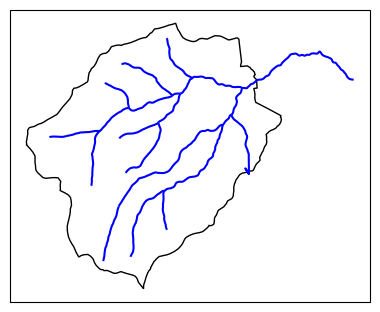

In [135]:
# quick look at rivers and watershed boundary
fig = plt.figure(figsize=(4,4))
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
watershed_workflow.plot.hucs(watershed, crs, 'k', ax)
watershed_workflow.plot.rivers(rivers, crs, 'b', ax)

plt.show()

### Simplify

In [136]:
simplify = 60 # length scale to target average edge, ; set this as 1 or 2 when using new densify 
snap_tol = 40
# keeping the originals
rivers_orig=[river.deepcopy() for river in rivers]
watershed_orig=copy.deepcopy(watershed) 

# simplifying 
rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=simplify, simplify_rivers=simplify,
                            snap_tol=snap_tol, cut_intersections=True)

# for plotting purpose only
rivers_simplified=[river.deepcopy() for river in rivers] 
watershed_simplified=copy.deepcopy(watershed) 

2024-11-10 15:23:04,774 - root - INFO: 
2024-11-10 15:23:04,774 - root - INFO: Simplifying
2024-11-10 15:23:04,774 - root - INFO: ------------------------------
2024-11-10 15:23:04,775 - root - INFO: Simplifying rivers
2024-11-10 15:23:04,781 - root - INFO: Simplifying HUCs
2024-11-10 15:23:04,782 - root - INFO: Snapping river and HUC (nearly) coincident nodes
2024-11-10 15:23:04,784 - root - INFO:   snapping polygon segment boundaries to river endpoints
2024-11-10 15:23:04,786 - root - INFO:   snapping river endpoints to the polygon
2024-11-10 15:23:04,792 - root - INFO:     snapped river: (1446485.9598044618, -648038.6404259473) to (1446473.7321661005, -648003.3717252925)
2024-11-10 15:23:04,795 - root - INFO:   cutting at crossings
2024-11-10 15:23:04,795 - root - INFO: intersection found
2024-11-10 15:23:04,798 - root - INFO:   - cutting reach at external boundary of HUCs:
2024-11-10 15:23:04,799 - root - INFO:       split HUC boundary seg into 2 pieces
2024-11-10 15:23:04,799 - ro

Dual/multiple section: type = <class 'shapely.geometry.multipoint.MultiPoint'>
 point = MULTIPOINT (1446465.0991682995 -648006.3647806965, 1446473.7321661005 -648003.3717252925)


CutError: Dual/multiple intersection in a single seg... ugh!  Intersection is of type '<class 'shapely.geometry.multipoint.MultiPoint'>'

This error is because a reach has two intersections with the watershed boundary, a case of inconsistent data of mapped flowlines for river and watershed boundary. As a remedy, we could either trim the reach or move the river or watershed boundary segment. 

### 1) Trim the reach

We can get the problematic node using either node ID (if the dataset is from NHDPlus, this is NHD_ID).

In [138]:
# revert to original river
rivers =[river.deepcopy() for river in rivers_orig]

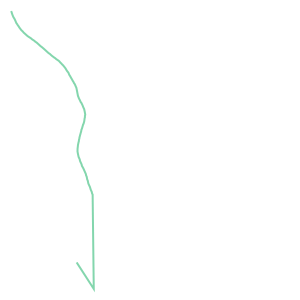

In [139]:
## get the problematic node
river= rivers[0]
node_id = '25000400108019'
node = river.getNode(node_id)
node.segment

Plotting original and simplified-pruned rivers and watershed


In [140]:
trimmed_reach_segment = trim_linestring(node.segment, 0.25, from_start=True) # Trims from start

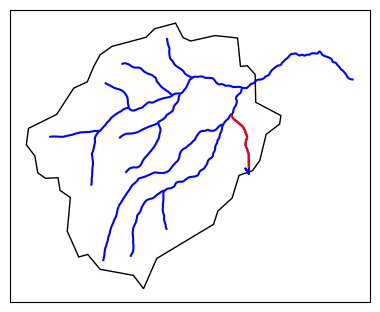

In [141]:
# let's have a loot at trimmed node
# quick look at rivers and watershed boundary
fig = plt.figure(figsize=(4,4))
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
watershed_workflow.plot.hucs(watershed, crs, 'k', ax)
watershed_workflow.plot.rivers(rivers, crs, 'b', ax)
watershed_workflow.plot.shply(trimmed_reach_segment, crs, 'r', ax)
plt.show()

In [142]:
# assign the edited reach segment back to the node
node.segment = trimmed_reach_segment

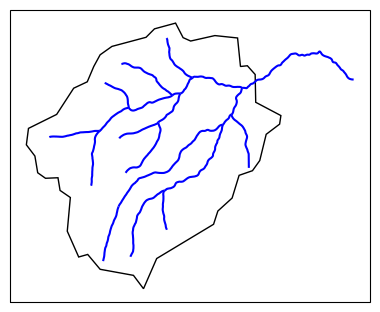

In [143]:
# quick look at rivers and watershed boundary after editing river
fig = plt.figure(figsize=(4,4))
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
watershed_workflow.plot.hucs(watershed, crs, 'k', ax)
watershed_workflow.plot.rivers(rivers, crs, 'b', ax)
plt.show()

In [144]:
# simplifying 
rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=simplify, simplify_rivers=simplify,
                            snap_tol=0.75*simplify, cut_intersections=True)

# for plotting purpose only
rivers_simplified=[river.deepcopy() for river in rivers] 
watershed_simplified=copy.deepcopy(watershed) 

2024-11-10 15:23:12,153 - root - INFO: 
2024-11-10 15:23:12,154 - root - INFO: Simplifying
2024-11-10 15:23:12,154 - root - INFO: ------------------------------
2024-11-10 15:23:12,155 - root - INFO: Simplifying rivers
2024-11-10 15:23:12,161 - root - INFO: Simplifying HUCs
2024-11-10 15:23:12,162 - root - INFO: Snapping river and HUC (nearly) coincident nodes
2024-11-10 15:23:12,165 - root - INFO:   snapping polygon segment boundaries to river endpoints
2024-11-10 15:23:12,168 - root - INFO:   snapping river endpoints to the polygon
2024-11-10 15:23:12,178 - root - INFO:   cutting at crossings
2024-11-10 15:23:12,179 - root - INFO: intersection found
2024-11-10 15:23:12,180 - root - INFO:   - cutting reach at external boundary of HUCs:
2024-11-10 15:23:12,181 - root - INFO:       split HUC boundary seg into 1 pieces
2024-11-10 15:23:12,181 - root - INFO:       split reach seg into 2 pieces
2024-11-10 15:23:12,183 - root - INFO: intersection found
2024-11-10 15:23:12,185 - root - INFO:

In [145]:
river.is_continuous()

True

### 2) Remove the reach

We can get the problematic node using either node ID (if the dataset is from NHDPlus, this is NHD_ID).

In [146]:
# revert to original river
rivers =[river.deepcopy() for river in rivers_orig]

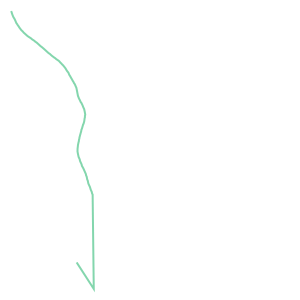

In [147]:
## get the problematic node
river= rivers[0]
node_id = '25000400108019'
node = river.getNode(node_id)
node.segment

In [148]:
# remove the problematic node
node.remove()

1

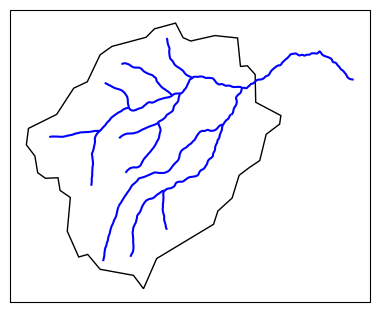

In [149]:
# quick look at rivers to see if the problematic node is removed
fig = plt.figure(figsize=(4,4))
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
watershed_workflow.plot.hucs(watershed, crs, 'k', ax)
watershed_workflow.plot.rivers(rivers, crs, 'b', ax)
plt.show()

In [150]:
river.is_continuous()

True

### 3) Nudge the reach

We can get the problematic node using either node ID (if the dataset is from NHDPlus, this is NHD_ID).

In [151]:
# revert to original river
rivers =[river.deepcopy() for river in rivers_orig]

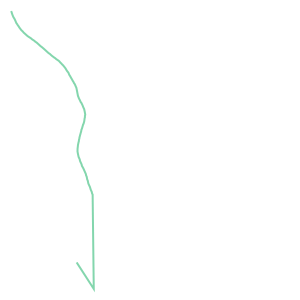

In [152]:
## get the problematic node
river= rivers[0]
node_id = '25000400108019'
node = river.getNode(node_id)
node.segment

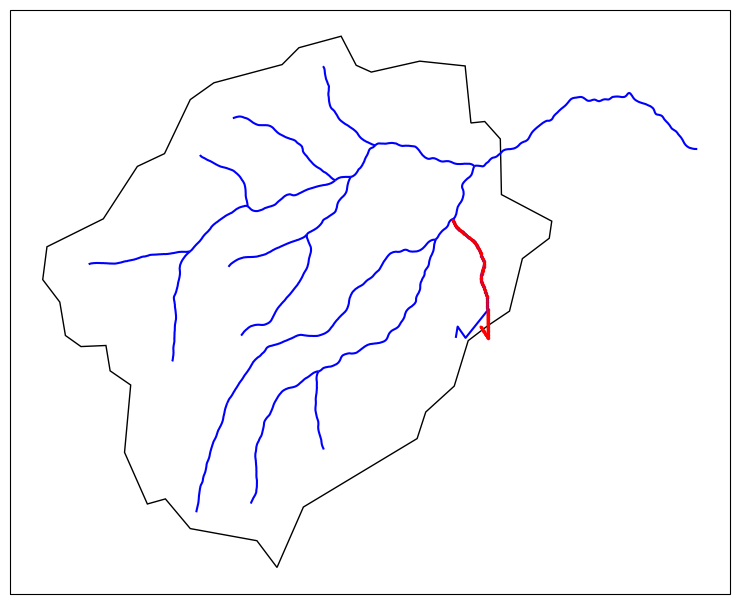

In [154]:
reach_backup = node.segment

# move some coordinates
for i in range(0,50):
    node.moveCoordinate(i, np.array(node.segment.coords[i]) + np.array([-320*(49-i)/50,0]))

# plot
fig = plt.figure(figsize=(8,8))
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
watershed_workflow.plot.hucs(watershed, crs, 'k', ax)
watershed_workflow.plot.rivers(rivers, crs, 'b', ax)
watershed_workflow.plot.shply(reach_backup, crs, 'r', ax, marker='x', markersize=2)
plt.show()


# # revert that change!
# river.segment = reach_backup

In [155]:
# simplifying 
rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=simplify, simplify_rivers=simplify,
                            snap_tol=0.75*simplify, cut_intersections=True)

# for plotting purpose only
rivers_simplified=[river.deepcopy() for river in rivers] 
watershed_simplified=copy.deepcopy(watershed) 

2024-11-10 15:23:12,925 - root - INFO: 
2024-11-10 15:23:12,925 - root - INFO: Simplifying
2024-11-10 15:23:12,926 - root - INFO: ------------------------------
2024-11-10 15:23:12,926 - root - INFO: Simplifying rivers
2024-11-10 15:23:12,931 - root - INFO: Simplifying HUCs
2024-11-10 15:23:12,932 - root - INFO: Snapping river and HUC (nearly) coincident nodes
2024-11-10 15:23:12,934 - root - INFO:   snapping polygon segment boundaries to river endpoints
2024-11-10 15:23:12,938 - root - INFO:   snapping river endpoints to the polygon
2024-11-10 15:23:12,948 - root - INFO:   cutting at crossings
2024-11-10 15:23:12,949 - root - INFO: intersection found
2024-11-10 15:23:12,950 - root - INFO:   - cutting reach at external boundary of HUCs:
2024-11-10 15:23:12,951 - root - INFO:       split HUC boundary seg into 1 pieces
2024-11-10 15:23:12,951 - root - INFO:       split reach seg into 2 pieces
2024-11-10 15:23:12,955 - root - INFO: Cutting crossings and removing external segments
2024-11-

In [156]:
river.is_continuous()

True